# Synthetic Data Generation

##### imports:

In [8]:
import numpy as np
import kinetics as kin

In [9]:
# Create a vector of size N with random values between 0 and 1
N = 200;
vector = np.random.rand(N)

# Print the vector (optional)
print(vector)


[0.01450526 0.96895522 0.53649512 0.63335133 0.14345531 0.10437065
 0.59219343 0.48976974 0.01690828 0.36719021 0.11438254 0.3551452
 0.38075664 0.52278881 0.38962299 0.23285783 0.17684948 0.98505354
 0.0252208  0.58196112 0.13041589 0.37878607 0.84327057 0.52660147
 0.88818796 0.28670369 0.20640701 0.02733254 0.98772485 0.54288096
 0.20271872 0.58564839 0.96030728 0.86325151 0.57210075 0.878168
 0.13259445 0.23437298 0.34430666 0.66303477 0.51087312 0.13152296
 0.33732384 0.70005418 0.65009788 0.07881968 0.04437363 0.71231374
 0.59792193 0.9463861  0.93589437 0.65795192 0.93312798 0.08491926
 0.63334237 0.0986843  0.34885249 0.51193565 0.70404177 0.5647841
 0.52588844 0.29061415 0.42242048 0.35227649 0.66476598 0.76982482
 0.20873514 0.53404506 0.84822227 0.27892083 0.99189338 0.00934825
 0.77867526 0.75786166 0.94556139 0.88860976 0.48934971 0.77249766
 0.75628978 0.64955375 0.74115854 0.77249099 0.9661778  0.91062449
 0.89796246 0.92608363 0.97272741 0.78231409 0.34396517 0.82519842

### Use the vector as an initial condition for a simple dynamical system modeling Michaelis-Menten kinetics

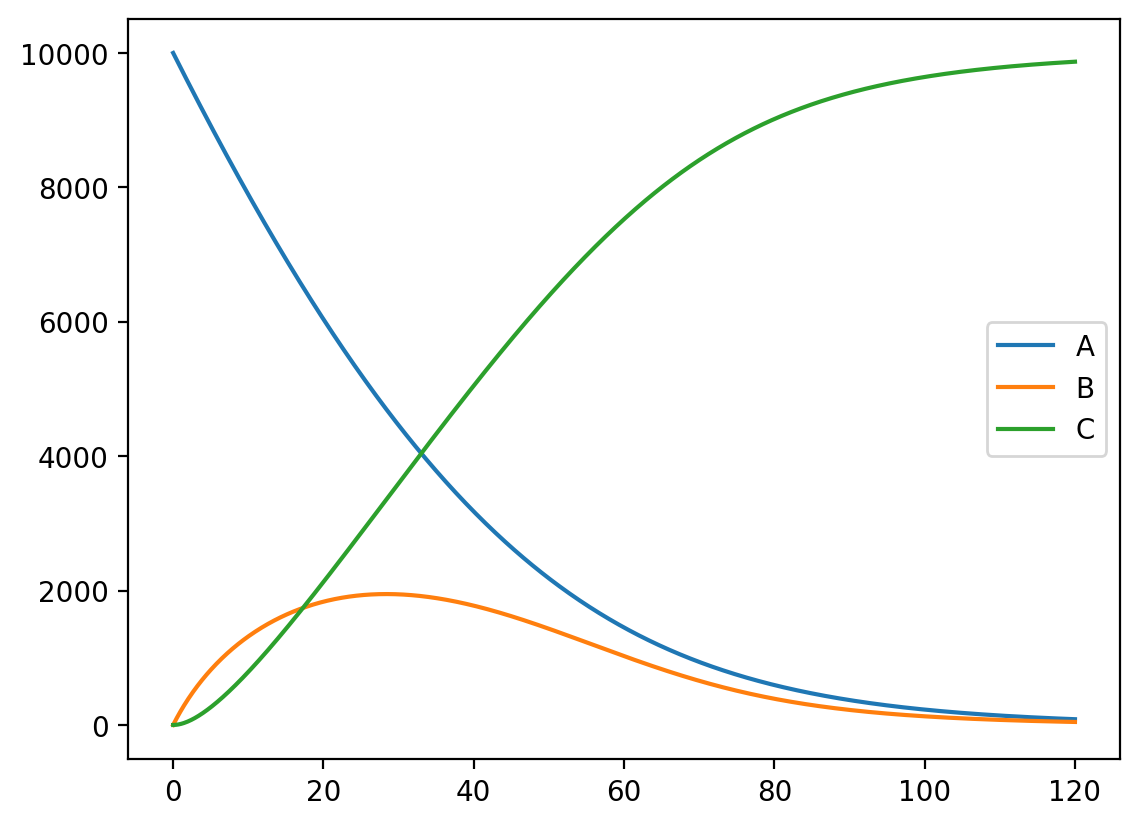

In [10]:
# Uncomment and run this if using google colab
# !pip install kinetics

import kinetics
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

# Define reactions
enzyme_1 = kinetics.Uni(kcat='enz1_kcat', kma='enz1_km', enz='enz_1', a='A',
                        substrates=['A'], products=['B'])

enzyme_1.parameters = {'enz1_kcat' : 100,
                       'enz1_km' : 8000}

enzyme_2 = kinetics.Uni(kcat='enz2_kcat', kma='enz2_km', enz='enz_2', a='B',
                        substrates=['B'], products=['C'])

enzyme_2.parameters = {'enz2_kcat' : 30,
                       'enz2_km' : 2000}

# Set up the model
model = kinetics.Model(logging=False)
model.append(enzyme_1)
model.append(enzyme_2)
model.set_time(0, 120, 1000) # 120 mins, 1000 timepoints.

# Set starting concentrations
model.species = {"A" : 10000,
                 "enz_1" : 4,
                 "enz_2" : 10}
model.setup_model()

# Run the model
model.run_model()
model.plot_substrate('A')
model.plot_substrate('B')
model.plot_substrate('C', plot=True)

# Now try altering the enzyme concentration, km or kcat, and re-running the model to see the effects this has....

# Something that copilot suggested

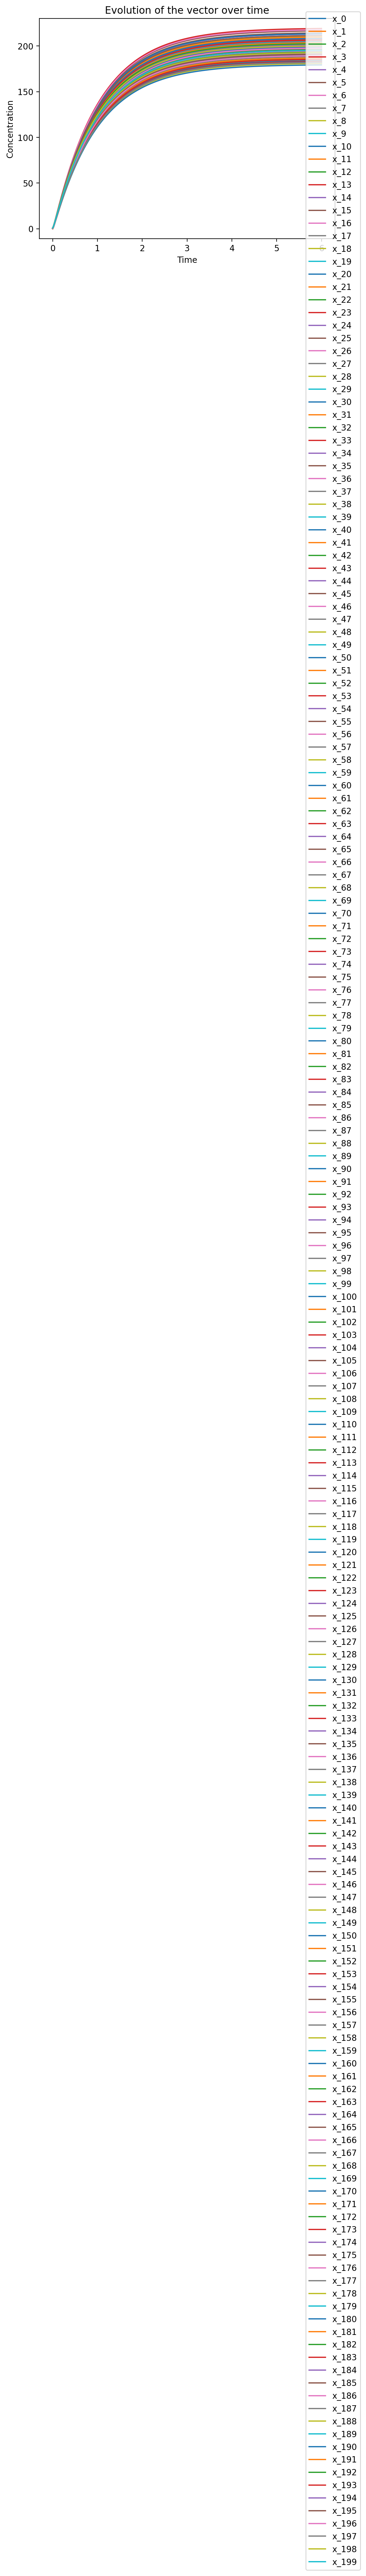

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the ODE system
def ode_system(x, t, W):
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N))
        dxdt[i] = -x[i] + sum_term
    return dxdt

# Initialize parameters
N = 200
vector = np.random.rand(N)
W = np.random.uniform(0, 2, (N, N))  # Random weight matrix with values between 0 and 2

# Set up the time points
t = np.linspace(0, 6, 1000)  # 120 mins, 1000 timepoints

# Run the simulation
result = odeint(ode_system, vector, t, args=(W,))

# Plot the results
for i in range(N):
    plt.plot(t, result[:, i], label=f'x_{i}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Evolution of the vector over time')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.show()

another one

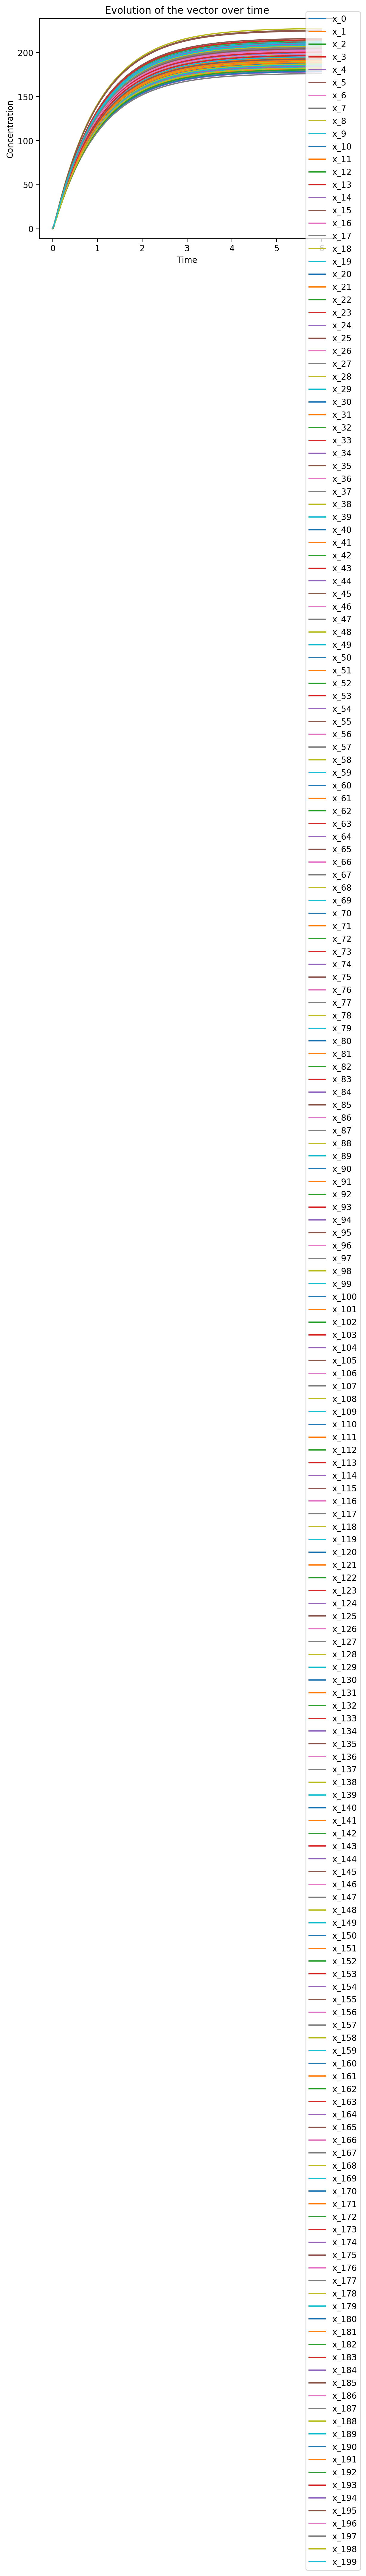

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Import the odeint function from scipy for solving ODEs

# Define the ODE system function
def ode_system(x, t, W): # t must be passed even if not used
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element (list comprehension ftw 😎)
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N))
        derivative_vector[i] = -x[i] + sum_term  # Compute the derivative for the i-th element
    return derivative_vector  # Return the derivative vector

# Initialize parameters
N = 200  # Set the number of elements in the state vector
vector = np.random.rand(N)  # Create a random initial state vector with values between 0 and 1
W = np.random.uniform(0, 2, (N, N))  # Create a random weight matrix with values between 0 and 2

# Set up the time points for the simulation
t = np.linspace(0, 6, 1000)  # Create an array of 1000 time points from 0 to 6

# Run the simulation using the odeint function
result = odeint(ode_system, vector, t, args=(W,))  # Solve the ODE system

# Plot the results
for i in range(N):  # Loop over each element in the state vector
    plt.plot(t, result[:, i], label=f'x_{i}')  # Plot the evolution of the i-th element over time
plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Concentration')  # Set the y-axis label
plt.title('Evolution of the vector over time')  # Set the plot title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))  # Add a legend to the plot
plt.show()  # Display the plot